In [1]:
#Necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from math import sqrt
import datetime 
import calendar
import sys
import matplotlib.pyplot as plt

In [2]:
# Load data
file_path = r'C:\Users\PHIRI003\OneDrive - Wageningen University & Research\Documents\WEcR Internship\Work\Eggs\Eggs.xlsx'
df = pd.read_excel(file_path, header=0)

#datetime index
df.index = df['Date']


In [3]:
# Define the function to create seasonal dummy variables

def SeasonalDummies(df, frequency='M'):
    nT = len(df)  # Number of observations
    startdate = df.index[0]  # Start date of the time series
    datetime = pd.DataFrame(data=pd.date_range(startdate, periods=nT, freq=frequency), columns=["datetime"])
    monthnumber = datetime["datetime"].dt.month  # Extract month numbers
    monthname = pd.DataFrame()  # DataFrame to store month names
    
    for i in range(nT):
        monthname.at[i, 'D'] = calendar.month_name[monthnumber[i]]  # Assign month names based on month numbers
    
    seasdum = pd.get_dummies(monthname)  # Create dummy variables for each month
    seasdum = seasdum.drop('D_January', axis=1)  # Drop January to avoid multicollinearity
    seasdum = seasdum.set_index(df.index)  # Set the index to match the original DataFrame
    seasdum = seasdum.astype(int)
    return seasdum

# Create seasonal dummies
seasdum = SeasonalDummies(df)

# Combine the data with the seasonal dummy variables
df = pd.concat([df, seasdum], axis=1)


In [5]:
import itertools
from itertools import combinations
import statsmodels.api as sm


# Define the function to perform the zivot-andrews test with seasonal dummies
def za_test(y, seasdum, max_lag=12, num_breaks=1):
    nT = len(y)
    m = 4  # Minimum distance between breaks
    h = int(nT * 0.15)  # Minimum distance from the start and end
    
    best_t_stat = float('inf')
    best_breaks = None
    unit_root_stat = None
    
    # Generate all possible combinations of break points
    potential_breaks = range(h, nT - h)
    all_combinations = list(itertools.combinations(potential_breaks, num_breaks))
    
    for breaks in all_combinations:
        if all(abs(breaks[i] - breaks[i-1]) >= m for i in range(1, num_breaks)):
            X = seasdum.copy()
            for i, bp in enumerate(breaks):
                X[f'break_{i}'] = (np.arange(nT) >= bp).astype(int) #break in levels
                X[f'break_trend_{i}'] = X[f'break_{i}'] * np.arange(nT)  #break in trend
            X['const'] = 1 #constat term
            X['trend'] = np.arange(nT)
            
            # Add lagged differences
            for lag in range(1, max_lag + 1):
                X[f'lag_{lag}'] = y.diff(lag).shift(lag)
            
            # Drop rows with NaN values from diff and lags
            X = X.dropna()
            y_valid = y[X.index]
            
            # Ensuring all columns in X are numeric
            X = X.apply(pd.to_numeric, errors='coerce')
            
            # Fit the model
            model = sm.OLS(y_valid, X).fit()
            t_stat = min(abs(model.tvalues[f'break_{i}']) for i in range(num_breaks))
            ur_stat = model.tvalues.iloc[1]  # t-statistic for the lagged level term 
            
            if abs(t_stat) < abs(best_t_stat):
                best_t_stat = t_stat
                best_breaks = breaks
                unit_root_stat = ur_stat
                
    return best_breaks, best_t_stat, unit_root_stat

# Example usage
for column in ['API', 'CPI', 'Oil', 'CornPI']:
    print(f"\nZivot-Andrews test for {column}:")
    break_points, t_stat, unit_root_stat = za_test(df[column], seasdum)
    
    print("Best break points:", [df.index[bp] for bp in break_points])
    print("T-statistic at best break points:", t_stat)
    print("Unit root test statistic:", unit_root_stat)



Zivot-Andrews test for API:
Best break points: [Timestamp('2013-10-01 00:00:00')]
T-statistic at best break points: 0.05635659804076107
Unit root test statistic: 0.27393695812280205

Zivot-Andrews test for CPI:
Best break points: [Timestamp('2012-03-01 00:00:00')]
T-statistic at best break points: 0.023676973134154736
Unit root test statistic: 0.38657142075636564

Zivot-Andrews test for Oil:
Best break points: [Timestamp('2012-04-01 00:00:00')]
T-statistic at best break points: 0.04088258888547021
Unit root test statistic: 0.3335977015945567

Zivot-Andrews test for CornPI:
Best break points: [Timestamp('2013-11-01 00:00:00')]
T-statistic at best break points: 0.17376672214936806
Unit root test statistic: -1.4060622211442197



Analysis for API:
Lumsdaine-Papell best break points: [Timestamp('2017-07-01 00:00:00'), Timestamp('2020-03-01 00:00:00')]
T-statistic at best break points: 0.00017947626512134098
Unit root test statistic: 0.47817313890572205
Bai-Perron breakpoints: [Timestamp('2012-02-01 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2022-07-01 00:00:00')]
Similar breaks between methods: []


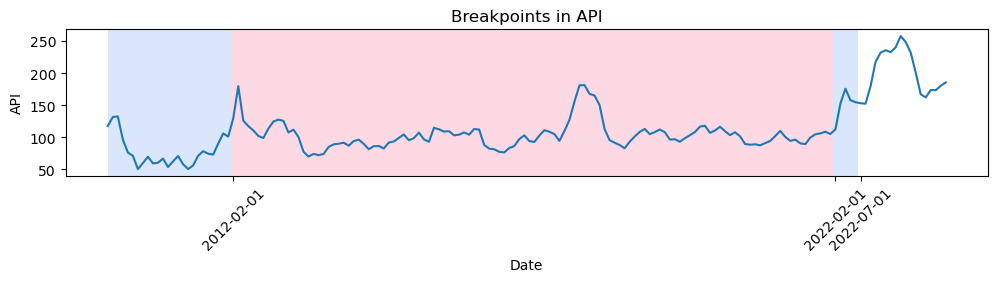


Analysis for CPI:
Lumsdaine-Papell best break points: [Timestamp('2013-10-01 00:00:00'), Timestamp('2014-02-01 00:00:00')]
T-statistic at best break points: 0.00023235973838551244
Unit root test statistic: 0.43704436825535964
Bai-Perron breakpoints: [Timestamp('2017-07-01 00:00:00'), Timestamp('2018-10-01 00:00:00'), Timestamp('2022-07-01 00:00:00')]
Similar breaks between methods: []


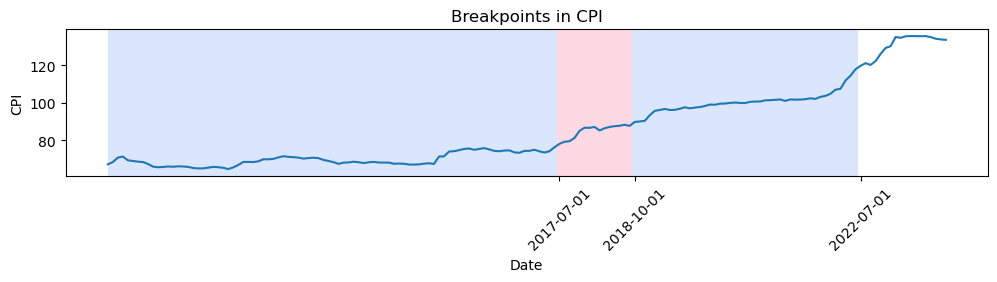


Analysis for Oil:
Lumsdaine-Papell best break points: [Timestamp('2012-10-01 00:00:00'), Timestamp('2015-07-01 00:00:00')]
T-statistic at best break points: 0.00025361168241004475
Unit root test statistic: 0.6865523398515487
Bai-Perron breakpoints: [Timestamp('2010-11-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2021-09-01 00:00:00')]
Similar breaks between methods: []


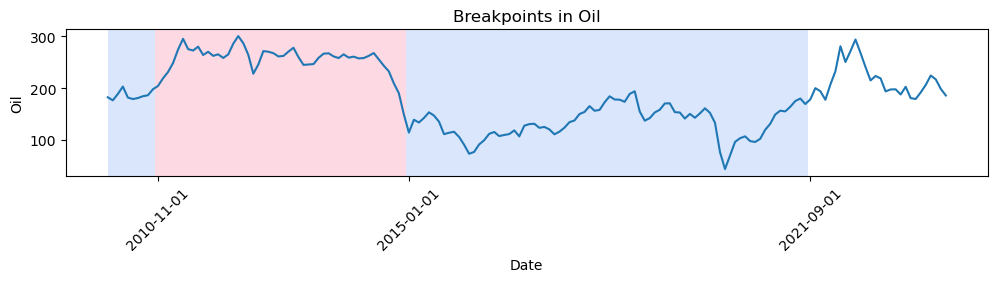


Analysis for CornPI:
Lumsdaine-Papell best break points: [Timestamp('2012-06-01 00:00:00'), Timestamp('2021-03-01 00:00:00')]
T-statistic at best break points: 0.00023221199446370799
Unit root test statistic: -1.8086030860247448
Bai-Perron breakpoints: [Timestamp('2010-11-01 00:00:00'), Timestamp('2013-10-01 00:00:00'), Timestamp('2021-04-01 00:00:00')]
Similar breaks between methods: []


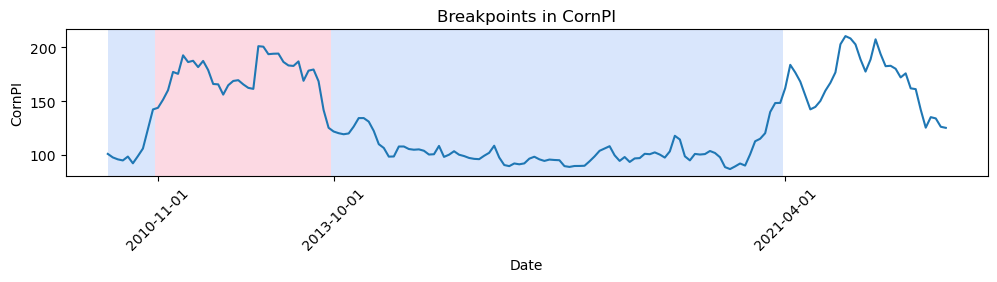

In [6]:
import itertools
import statsmodels.api as sm
import ruptures as rpt
import matplotlib.pyplot as plt

# Define the function to perform the Lumsdaine and Papell test with seasonal dummies
def lumsdaine_papell_with_seasonal_dummies(y, seasdum, max_lag=12, num_breaks=2):
    nT = len(y)
    m = 4  # Minimum distance between breaks
    h = int(nT * 0.15)  # Minimum distance from the start and end
    
    best_t_stat = float('inf')
    best_breaks = None
    unit_root_stat = None
    
    # Generate all possible combinations of break points
    potential_breaks = range(h, nT - h)
    all_combinations = list(itertools.combinations(potential_breaks, num_breaks))
    
    for breaks in all_combinations:
        if all(abs(breaks[i] - breaks[i-1]) >= m for i in range(1, num_breaks)):
            X = seasdum.copy()
            for i, bp in enumerate(breaks):
                X[f'break_{i}'] = (np.arange(nT) >= bp).astype(int) #break in levels
                X[f'break_trend_{i}'] = X[f'break_{i}'] * np.arange(nT)  #break in trend
            X['const'] = 1 #constant term
            X['trend'] = np.arange(nT)
            
            # Add lagged differences and autoregressive component
            for lag in range(1, max_lag + 1):
                X[f'lag_{lag}'] = y.diff(lag).shift(lag)
            
            # Drop rows with NaN values
            X = X.dropna()
            y_valid = y[X.index]
            
            # Ensure all columns in X are numeric
            X = X.apply(pd.to_numeric, errors='coerce')
            
            # Fit the model
            model = sm.OLS(y_valid, X).fit()
            t_stat = min(abs(model.tvalues[f'break_{i}']) for i in range(num_breaks))
            ur_stat = model.tvalues.iloc[1]  # t-statistic for the lagged level term (usually the second parameter)
            
            if abs(t_stat) < abs(best_t_stat):
                best_t_stat = t_stat
                best_breaks = breaks
                unit_root_stat = ur_stat
                
    return best_breaks, best_t_stat, unit_root_stat

# Function to apply Bai-Perron test and find breakpoints
def bai_perron_breakpoints(y, n_bkps=3):
    ts = y.dropna()
    adjusted_index = ts.index
    ts_values = ts.values.reshape(-1, 1)
    
    # Apply the Bai-Perron test
    model = "l2"  # least squares
    algo = rpt.Binseg(model=model).fit(ts_values)
    
    result = algo.predict(n_bkps=n_bkps)
    
    # Convert breakpoint indices to dates
    break_dates = [adjusted_index[i] for i in result if i < len(adjusted_index)]
    
    return break_dates

# Function to identify similar breaks between the two methods
def find_similar_breaks(lumsdaine_breaks, bai_perron_breaks, tolerance=2):
    similar_breaks = []
    for lb in lumsdaine_breaks:
        for bp in bai_perron_breaks:
            if abs((lb - bp).days) <= tolerance:  # Compare the difference in days
                similar_breaks.append((lb, bp))
    return similar_breaks


# Example usage
for column in ['API', 'CPI', 'Oil', 'CornPI']:
    print(f"\nAnalysis for {column}:")
    
    # Lumsdaine and Papell test
    lumsdaine_breaks, t_stat, unit_root_stat = lumsdaine_papell_with_seasonal_dummies(df[column], seasdum)
    lumsdaine_breaks_dates = [df.index[bp] for bp in lumsdaine_breaks]
    
    print("Lumsdaine-Papell best break points:", lumsdaine_breaks_dates)
    print("T-statistic at best break points:", t_stat)
    print("Unit root test statistic:", unit_root_stat)
    
    # Bai-Perron test
    bai_perron_breaks = bai_perron_breakpoints(df[column])
    
    print("Bai-Perron breakpoints:", bai_perron_breaks)
    
    # Find similar breaks
    similar_breaks = find_similar_breaks(lumsdaine_breaks_dates, bai_perron_breaks)
    print("Similar breaks between methods:", similar_breaks)
    
    # Plot Bai-Perron breakpoints
    ts = df[column].dropna()
    adjusted_index = ts.index
    ts_values = ts.values.reshape(-1, 1)
    rpt.display(ts_values, [adjusted_index.get_loc(d) for d in bai_perron_breaks if d in adjusted_index])
    plt.title(f'Breakpoints in {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(ticks=[adjusted_index.get_loc(d) for d in bai_perron_breaks if d in adjusted_index], 
               labels=[d.strftime('%Y-%m-%d') for d in bai_perron_breaks], 
               rotation=45)
    plt.savefig(f'{column}_breakpoints.png', bbox_inches='tight')
    plt.show()
